## Bayesian parameter estimation using MCMC

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

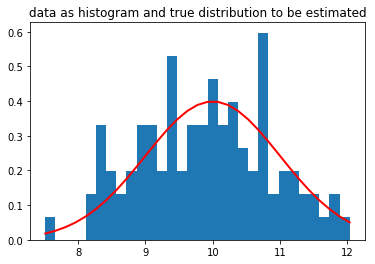

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','inv_gamma'], prior_params = [[0, 15], [1, 0, 1]], 
                        prior_type='marginal_pdf')

In [4]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal_type = 'Normal', pdf_proposal_scale=1, model=candidate_model, 
                                           algorithm = 'MMH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

UQpy: Running parameter estimation for candidate model: normal
Successful execution of the MCMC design
UQpy: Parameter estimation analysis completed!


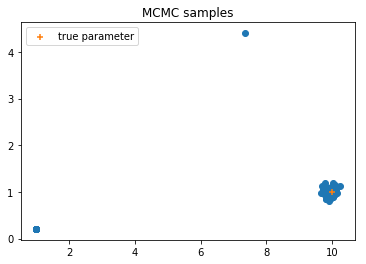

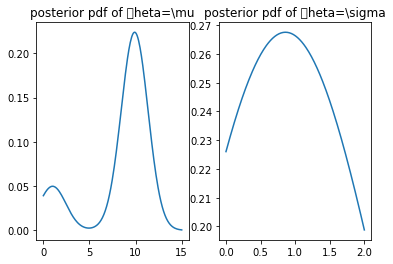

In [5]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')

data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[-9.56807452e-01 -1.64405615e-01 -9.25758916e-01  1.08014729e+00
  2.42722756e+00  1.95454934e+00  4.26310027e+00  7.04569888e+00
  6.11120057e+00  8.23237409e+00  1.14808981e+01  1.20903106e+01
  1.46695895e+01  1.82956611e+01  1.94839152e+01  2.11296327e+01
  2.42794736e+01  2.72836265e+01  3.06666624e+01  3.44897078e+01
  3.69902661e+01  4.10751028e+01  4.47168234e+01  4.79945270e+01
  5.20995235e+01  5.68344469e+01  6.12544761e+01  6.61970115e+01
  7.17892168e+01  7.54711032e+01  8.14823749e+01  8.85939020e+01
  9.17490429e+01  9.67056376e+01  1.03928961e+02  1.09707707e+02
  1.15985099e+02  1.21657130e+02  1.29782157e+02  1.34267156e+02
  1.43052976e+02  1.49128782e+02  1.53812007e+02  1.62816030e+02
  1.69344543e+02  1.78543556e+02  1.86227262e+02  1.95270409e+02
  2.01213265e+02  2.09212118e+02]


In [7]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [11]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=3000,
                                           algorithm = 'MH', jump=10, nburn=0, pdf_proposal_type = 'Normal',
                                           pdf_proposal_scale = [0.0005, 0.001], seed = [0.5, 2.5])

UQpy: Running parameter estimation for candidate model
Successful execution of the MCMC design
UQpy: Parameter estimation analysis completed!


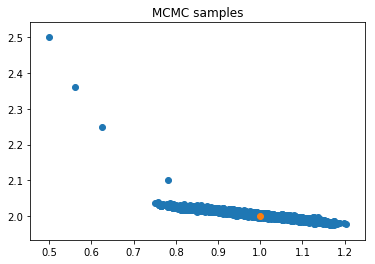

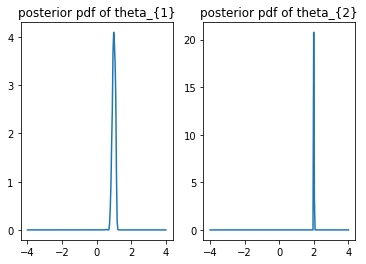

In [18]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

Acceptance ratio of the chain = 0.12137071235707857
Multivariate ESS = 17537.893268368804, minESS = 7529.096402175249
Univariate ESS in each dimension
Parameter 1: ESS = 5697.592758093477, minESS = 6146.334113110603
Parameter 2: ESS = 10654.444366674395, minESS = 6146.334113110603


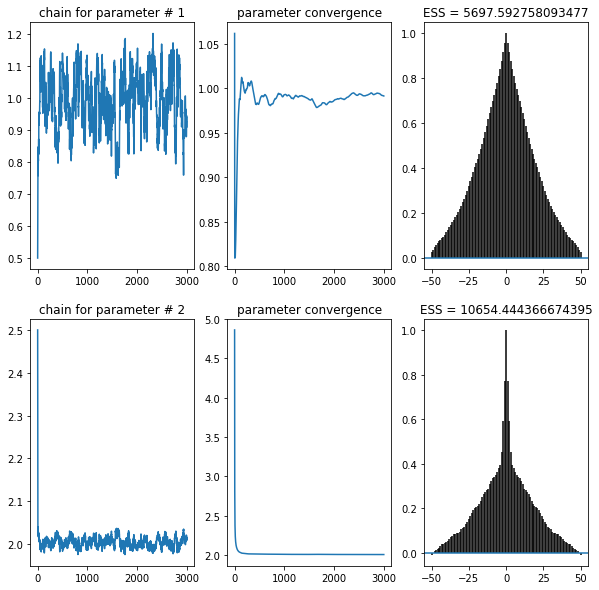

In [19]:
Diagnostics(sampling_method='MCMC', sampling_outputs = bayes_estimator)